# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [164]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
np.random.seed(2020)
random.seed(2020)

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [165]:
PATH = 'data'
df = pd.read_csv(PATH+'/sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

## Gini index

In [167]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)

In [168]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [169]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [170]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

-0.0003705758273065962

## Entropy

In [171]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [172]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

# Split function

Implement split functions

In [173]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [174]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. Explain the results.

In [175]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [176]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [177]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


# Random forest

In [178]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. Explain the results.

In [179]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


In [180]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.8809523809523809


Now it's your turn to explore the various parameters of sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and their influence on model quality.

# Homework part 1. RandomForestClassifier

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

In [181]:
from sklearn.ensemble import RandomForestClassifier as skLearnRandomForestClassifier

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [182]:
def train_test_val_split(X, y, train_size, test_size, val_size):
    arr = np.arange(len(y))
    np.random.shuffle(arr)
    train_idx, test_idx, val_idx = np.split(arr, [round(train_size * len(y)), round((test_size + train_size)*len(y))])
    return X.iloc[train_idx], X.iloc[test_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[test_idx], y.iloc[val_idx]

X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(df.drop(columns='target'), df['target'], 0.6, 0.2, 0.2)


**Task 2 (2 points)**. Apply '_greedy_' hyperparameter tuning of RandomForestClassifier model. '_Greedy_' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric. <br>

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time **if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.**<br>

Here is one of the possible options for RandomForestClassifier:
- Choose a decent value for number of trees using '_elbow_' rule. You may plot the dependence of accuracy on trees_num and pick up the number after which the error decreases not **as much as before**. 
- Pick up the best split criterion ('gini' / 'entropy') and then tune _max_depth_, _min_samples_split_, _min_samples_leaf_.
- Increase number of trees with best found parameters so far.
- Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps **if you observe a significant test metric improvement**. Otherwise just stop and measure your best model result on validation set.

In [183]:
# Use 'elbow' rule
results = [0]
estimators_count = np.arange(0, 500, 5)
for x in estimators_count[1:]:
    model = skLearnRandomForestClassifier(n_estimators=x)
    model.fit(X_train, y_train)
    results.append(accuracy_score(y_test, model.predict(X_test)))

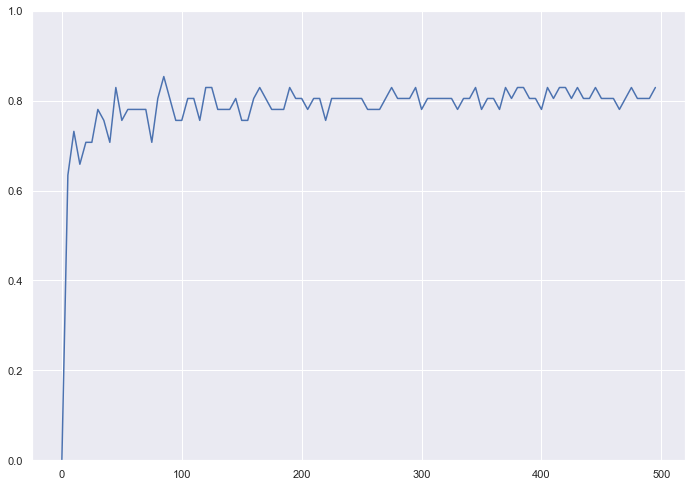

In [184]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(x=estimators_count, y=results)
ax.set_ylim([0,1])
plt.show()

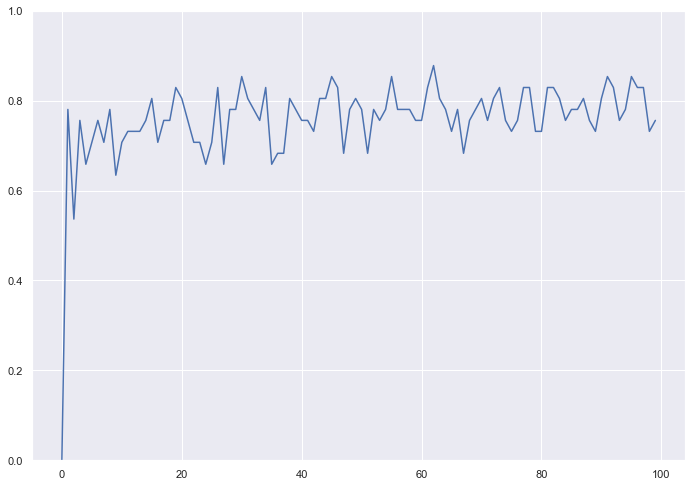

In [185]:
# One more elbow
results = [0]
estimators_count = np.arange(0, 100, 1)
for x in estimators_count[1:]:
    model = skLearnRandomForestClassifier(n_estimators=x)
    model.fit(X_train, y_train)
    results.append(accuracy_score(y_test, model.predict(X_test)))

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(x=estimators_count, y=results)
ax.set_ylim([0,1])
plt.show()

In [186]:
# Let's take 20 trees as starting point ("elbow" bend)
n = 20

best_params = {}

intervals = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, len(y_train)), 
    'min_samples_split': np.arange(2, len(y_train)), 
    'min_samples_leaf': np.arange(1, round(len(y_train)/2))
}

accuracy = 0
accuracy_improvement = 1000
max_current_accuracy = 0

while accuracy_improvement > 0.01: # threshold
    for param in intervals: # iterate over all params
        max_current_accuracy = 0
        best_param_val = None
        current_params = copy.copy(best_params) # copy current best params

        for param_value in intervals[param]: # iterate over current param values
            current_params[param] = param_value # replace with new value
            # Do fit-predict
            model = skLearnRandomForestClassifier(n_estimators=n, **current_params, random_state=42)
            model.fit(X_train, y_train)
            # Measure accuracy
            tmp_accuracy = accuracy_score(y_test, model.predict(X_test))
            # if it better then before - save the param value
            if (tmp_accuracy > max_current_accuracy):
                max_current_accuracy = tmp_accuracy
                best_param_val = param_value
        best_params[param] = best_param_val
        print(best_params)
        print(f'Best value for "{param}" is "{best_param_val}"')

    accuracy_improvement = max_current_accuracy - accuracy
    print(f'New accuracy: {max_current_accuracy} ({accuracy_improvement})')
    accuracy = max_current_accuracy
    n = n + 1 # Add one more tree and measure improvement
    model = skLearnRandomForestClassifier(n_estimators=n, **best_params, random_state=42)
    model.fit(X_train, y_train)
    new_accuracy = accuracy_score(y_test, model.predict(X_test))
    if (new_accuracy <= max_current_accuracy): # stop if accuracy falls down
        print(f'Accuracy on n={n}: {new_accuracy} ({accuracy}) => stop')
        n = n - 1
        break
    else:
        print(f'Accuracy on n={n}: {new_accuracy} ({accuracy}) => repeat')
        accuracy = new_accuracy
        
best_params['n_estimators'] = n
print(f'Best params: {best_params}')

# Check best model
model = skLearnRandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)
print(f'Best model accuracy on validation dataset is {accuracy_score(y_val, model.predict(X_val))}')

{'criterion': 'gini'}
Best value for "criterion" is "gini"
{'criterion': 'gini', 'max_depth': 4}
Best value for "max_depth" is "4"
{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}
Best value for "min_samples_split" is "2"
{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 34}
Best value for "min_samples_leaf" is "34"
New accuracy: 0.8292682926829268 (0.8292682926829268)
Accuracy on n=21: 0.7560975609756098 (0.8292682926829268) => stop
Best params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 34, 'n_estimators': 20}
Best model accuracy on validation dataset is 0.8809523809523809


### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

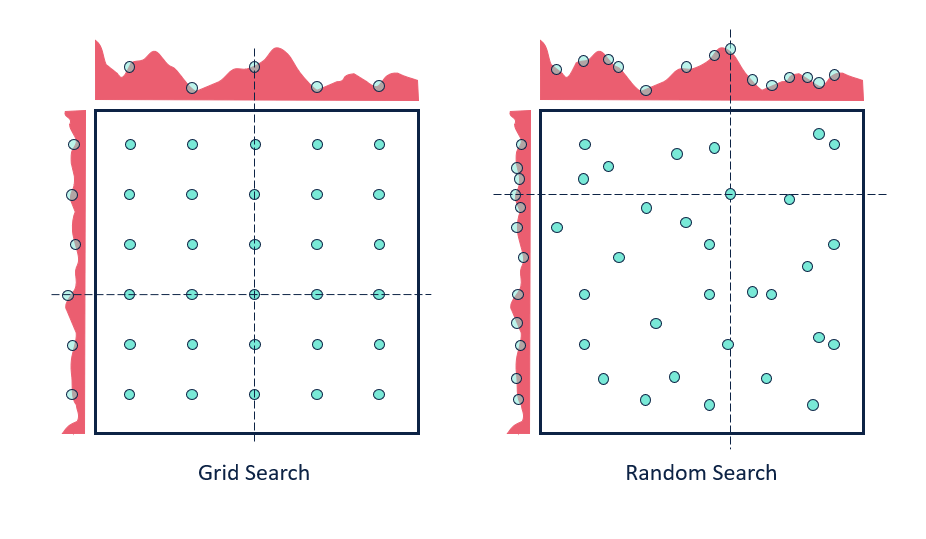

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [187]:
parameters = {'criterion': ('gini', 'entropy'), 
 'max_depth': np.arange(1, 7), 
 'min_samples_split': np.arange(2, 10), 
 'min_samples_leaf': np.arange(1, 40)}

max_accuracy_on_valid = 0
best_params = {}
for n in np.arange(1, 8):
    grid_search = GridSearchCV(estimator=skLearnRandomForestClassifier(random_state=42, n_estimators=n), 
                               param_grid=parameters, 
                               scoring='accuracy', n_jobs=-1, cv=3).fit(X_train.append(X_test), y_train.append(y_test))

    accuracy_on_valid = accuracy_score(y_val, grid_search.predict(X_val))
    print(f'(n={n}) Best params by GridSearchCV:\n{grid_search.best_params_}')
    print(f'(n={n}) Best model accuracy on validation dataset is {accuracy_on_valid}')
    if (accuracy_on_valid - max_accuracy_on_valid > 0.01):
        max_accuracy_on_valid = accuracy_on_valid
        best_params = grid_search.best_params_
        best_params['n_estimators'] = n
    elif (accuracy_on_valid - max_accuracy_on_valid < -0.1):
        break
        
print(f'\nBest parameters for GridSearchCV:\n{best_params}')

(n=1) Best params by GridSearchCV:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 2}
(n=1) Best model accuracy on validation dataset is 0.7142857142857143
(n=2) Best params by GridSearchCV:
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2}
(n=2) Best model accuracy on validation dataset is 0.7857142857142857
(n=3) Best params by GridSearchCV:
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
(n=3) Best model accuracy on validation dataset is 0.8095238095238095
(n=4) Best params by GridSearchCV:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}
(n=4) Best model accuracy on validation dataset is 0.8571428571428571
(n=5) Best params by GridSearchCV:
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 3}
(n=5) Best model accuracy on validation dataset is 0.9285714285714286
(n=6) Best params by GridSearchCV:
{'crit

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [188]:
parameters = {'criterion': ('gini', 'entropy'), 
 'max_depth': np.arange(1, 7), 
 'min_samples_split': np.arange(2, 10), 
 'min_samples_leaf': np.arange(1, 40)}

max_accuracy_on_valid = 0
best_params = {}
for n in np.arange(1, 20):
    rnd_search = RandomizedSearchCV(estimator=skLearnRandomForestClassifier(random_state=42, n_estimators=n), 
                           param_distributions=parameters, random_state=42,
                           scoring='accuracy', n_jobs=-1, cv=3).fit(X_train.append(X_test), y_train.append(y_test))

    accuracy_on_valid = accuracy_score(y_val, rnd_search.predict(X_val))
    print(f'(n={n}) Best params by RandomizedSearchCV:\n{grid_search.best_params_}')
    print(f'(n={n}) Best model accuracy on validation dataset is {accuracy_on_valid}')
    if (accuracy_on_valid - max_accuracy_on_valid > 0.01):
        max_accuracy_on_valid = accuracy_on_valid
        best_params = grid_search.best_params_
        best_params['n_estimators'] = n
        
print(f'\nBest parameters for RandomizedSearchCV:\n{best_params}')

(n=1) Best params by RandomizedSearchCV:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}
(n=1) Best model accuracy on validation dataset is 0.8095238095238095
(n=2) Best params by RandomizedSearchCV:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1}
(n=2) Best model accuracy on validation dataset is 0.7619047619047619
(n=3) Best params by RandomizedSearchCV:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1}
(n=3) Best model accuracy on validation dataset is 0.8571428571428571
(n=4) Best params by RandomizedSearchCV:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 3}
(n=4) Best model accuracy on validation dataset is 0.9047619047619048
(n=5) Best params by RandomizedSearchCV:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 4}
(n=5) Best mod

**Comparing results**:
1. Accuracy on validation dataset:
    - _Greedy_: 0.8809523809523809
    - _GridSearchCV_: 0.9285714285714286
    - _RandomizedSearchCV_: 0.9523809523809523
1. Due to CPU limitations I can't run GridSearchCV on large number of trees - it's too slow
1. RandomizedSearchCV is much faster then other and gaves excellent results. But resulting number of trees is greater then produced by GridSearchCV. Resulting model might be slower in preditiction mode

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

**Cool ideas:** In my case RandomizedSearchCV is the best, just because it's fast. But is has a disadvantage: result depends on random_state, for good tuning it's better to have several iterations with different random_state value.

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [189]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn import tree
import matplotlib.pyplot as plt

titanic_df = pd.read_csv(PATH+'/titanic/train.csv')

titanic_df['Age']=titanic_df['Age'].fillna(titanic_df['Age'].median())
titanic_df['Embarked']=titanic_df['Embarked'].fillna('NA')
titanic_df = titanic_df.drop(columns=['Cabin']).drop(columns=['Name']).drop(columns=['Ticket'])
titanic_df['Sex']= LabelEncoder().fit_transform(titanic_df['Sex'])
titanic_df['Embarked']= LabelEncoder().fit_transform(titanic_df['Embarked'])
       

X_titanic_train, X_titanic_test, y_titanic_train, y_titanic_test = train_test_split(
    titanic_df.drop(columns=['Survived']), titanic_df['Survived'], test_size=0.2, random_state=2020)

parameters = {   'criterion': ('gini', 'entropy'),
                 'splitter': ('best', 'random'),
                 'max_depth': np.arange(1, 10), 
                 'min_samples_split': np.arange(2, 10), 
                 'min_samples_leaf': np.arange(1, 10)}

dec_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                           param_grid=parameters, n_jobs=-1).fit(X_titanic_train, y_titanic_train)

print(f'Accuracy on Titanic: {accuracy_score(y_titanic_test, dec_tree.predict(X_titanic_test))}')

Accuracy on Titanic: 0.7486033519553073


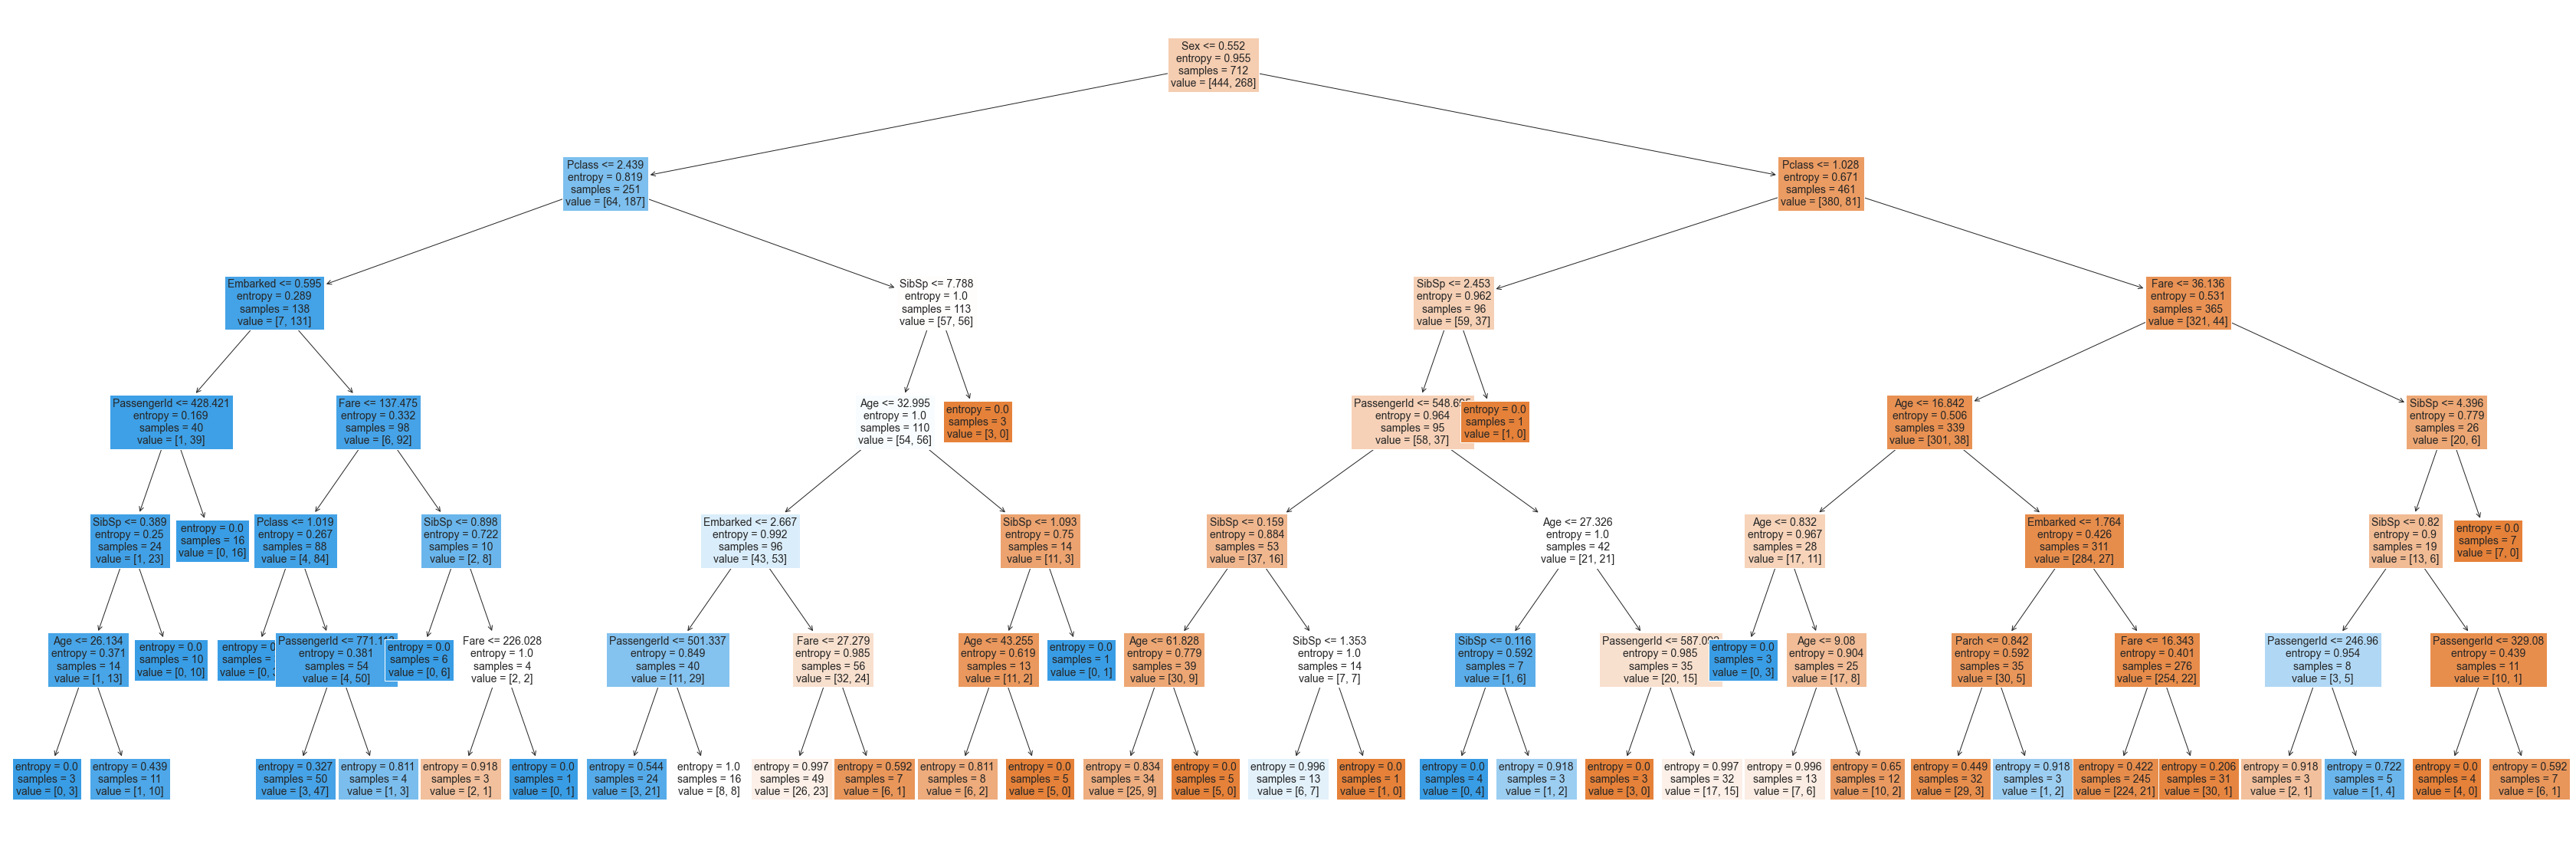

In [190]:
plt.figure(figsize=(60,20))
tree.plot_tree(dec_tree.best_estimator_, filled=True, fontsize=14, feature_names=X_titanic_train.columns)
plt.show()

Is it easy to interpret its results? Are you able to explain to a random person why would he survive / die on the titanic?

**Answer**: No, and no.

# Homework part 2. RandomForestRegressor

**Task 7 (2 points)**. Write your own *DecisionTreeRegressor* class with _MSE_ split criterion and settable parameter *max_depth*. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). <br>

Provide examples for different _max_depth_ parameter.

Of course you may re-use code for *DecisionTreeClassifier*. You need to figure out what needs to be changed in it for Classification -> Regression transformation.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [191]:
import numpy as np

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

In [192]:
def mean_squared_error(arr1, arr2):
    error = ((arr1 - arr2)**2).mean()
    return error
    
def mse(split):
    """ Calculate MSE for a split. Comparing values with mean value
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: MSE
    """     
    
    return mean_squared_error(split, np.repeat(np.mean(split), len(split)))

def mse_gain(parent_node, splits):
    """ Calculate MSE Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: MSE Gain
    """     
    splits_mse = np.sum([mse(split)*(len(split)/len(parent_node)) for split in splits])
    return mse(parent_node) - splits_mse

In [193]:
class DecisionTreeReg(object):
    def __init__(self, max_depth=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = mse_gain
        self.left_child = None
        self.right_child = None
        self.max_depth = max_depth

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
        """        
        try:
            # Exit from recursion using assert syntax
            if self.max_depth is not None:
                assert self.max_depth > 0

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = DecisionTreeReg(self.max_depth if self.max_depth == None else self.max_depth - 1)
            self.left_child.fit(left_X, left_target, n_features)

            self.right_child = DecisionTreeReg(self.max_depth if self.max_depth == None else self.max_depth - 1)
            self.right_child.fit(right_X, right_target, n_features)
        except AssertionError:
            # No rounding here
            self.outcome_probs = np.sum(y) / y.shape[0]


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

In [194]:
# Compare results with sklearn.tree.DecisionTreeRegressor. 
from sklearn.tree import DecisionTreeRegressor
X_p2_train, X_p2_test, y_p2_train, y_p2_test = train_test_split(X, y, test_size=0.2, random_state=42)

my_model = DecisionTreeReg()
my_model.fit(X_p2_train, y_p2_train)
my_pred_y = my_model.predict(X_p2_test)

ref_model = DecisionTreeRegressor(random_state=42)
ref_model.fit(X_p2_train, y_p2_train)
ref_pred_y = ref_model.predict(X_p2_test)

# Show MSE
print(f'Train MSE on custom model: {mean_squared_error(y_p2_train, my_model.predict(X_p2_train))}')
print(f'Train MSE on reference model: {mean_squared_error(y_p2_train, ref_model.predict(X_p2_train))}')
print(f'Test MSE on custom model: {mean_squared_error(y_p2_test, my_pred_y)}')
print(f'Test MSE on reference model: {mean_squared_error(y_p2_test, ref_pred_y)}')


Train MSE on custom model: 0.0
Train MSE on reference model: 0.0
Test MSE on custom model: 0.024100108740600357
Test MSE on reference model: 0.026292367198347037


**Conclusion**:
MSE for reference and custom models are the same for train dataset and very close for test dataset. Exact values for test dataset depend on randomness

In [195]:
# Check max_depth parameter
for md in np.arange(2, 6):
    my_model = DecisionTreeReg(max_depth=md)
    my_model.fit(X_p2_train, y_p2_train)
    my_pred_y = my_model.predict(X_p2_test)

    ref_model = DecisionTreeRegressor(max_depth=md, random_state=42)
    ref_model.fit(X_p2_train, y_p2_train)
    ref_pred_y = ref_model.predict(X_p2_test)

    print(f'Train MSE on custom model    (max_depth={md}): {mean_squared_error(y_p2_train, my_model.predict(X_p2_train))}')
    print(f'Train MSE on reference model (max_depth={md}): {mean_squared_error(y_p2_train, ref_model.predict(X_p2_train))}')
    print(f'Test MSE on custom model     (max_depth={md}): {mean_squared_error(y_p2_test, my_pred_y)}')
    print(f'Test MSE on reference model  (max_depth={md}): {mean_squared_error(y_p2_test, ref_pred_y)}')
    print('\n')

Train MSE on custom model    (max_depth=2): 0.016250507879817418
Train MSE on reference model (max_depth=2): 0.016250507879817418
Test MSE on custom model     (max_depth=2): 0.05452645478210631
Test MSE on reference model  (max_depth=2): 0.05452645478210631


Train MSE on custom model    (max_depth=3): 0.009302157840700733
Train MSE on reference model (max_depth=3): 0.009302157840700733
Test MSE on custom model     (max_depth=3): 0.03633266764704478
Test MSE on reference model  (max_depth=3): 0.03633266764704478


Train MSE on custom model    (max_depth=4): 0.005928219336435245
Train MSE on reference model (max_depth=4): 0.0059282193364352444
Test MSE on custom model     (max_depth=4): 0.0273208245806504
Test MSE on reference model  (max_depth=4): 0.0273208245806504


Train MSE on custom model    (max_depth=5): 0.003633119872457586
Train MSE on reference model (max_depth=5): 0.003633119872457587
Test MSE on custom model     (max_depth=5): 0.021143752933109335
Test MSE on reference mode

**Conclusion**:
Again, MSE for reference and custom models are the same for train dataset and very close for test dataset. Custom model looks good.

**Task 8 (2 points)**. Write your own _RandomForestRegressor_ class with MSE split criterion and settable parameter _max_depth_.  Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).<br>

Provide examples for different max_depth parameter.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [196]:
class RandomForestRegr(object):
    """
    A random forest regressor.
    A random forest is a meta estimator that fits a number of decision tree
    regressors on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        self.criterion = mse_gain
            
        self.trees = [DecisionTreeReg(max_depth=max_depth) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(X, y)
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])
                # No rounding here 
                predictions[i] = row_pred / self.n_estimators
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [197]:
# Compare results with sklearn.ensemble.RandomForestRegressor. 
from sklearn.ensemble import RandomForestRegressor

X_p2_train, X_p2_test, y_p2_train, y_p2_test = train_test_split(X, y, test_size=0.2, random_state=42)

my_model = RandomForestRegr(n_estimators=10)
my_model.fit(X_p2_train, y_p2_train)
my_pred_y = my_model.predict(X_p2_test)

ref_model = RandomForestRegressor(n_estimators=10, random_state=42)
ref_model.fit(X_p2_train, y_p2_train)
ref_pred_y = ref_model.predict(X_p2_test)

# Show MSE
print(f'Train MSE on custom model: {mean_squared_error(y_p2_train, my_model.predict(X_p2_train))}')
print(f'Train MSE on reference model: {mean_squared_error(y_p2_train, ref_model.predict(X_p2_train))}')
print(f'Test MSE on custom model: {mean_squared_error(y_p2_test, my_pred_y)}')
print(f'Test MSE on reference model: {mean_squared_error(y_p2_test, ref_pred_y)}')


Train MSE on custom model: 0.001816578873833543
Train MSE on reference model: 0.0023296990128340938
Test MSE on custom model: 0.019047273972169543
Test MSE on reference model: 0.017742860025179306


In [198]:
# Check max_depth parameter
for md in np.arange(2, 6):
    my_model = RandomForestRegr(max_depth=md)
    my_model.fit(X_p2_train, y_p2_train)
    my_pred_y = my_model.predict(X_p2_test)

    ref_model = RandomForestRegressor(max_depth=md, random_state=42)
    ref_model.fit(X_p2_train, y_p2_train)
    ref_pred_y = ref_model.predict(X_p2_test)

    print(f'Train MSE on custom model    (max_depth={md}): {mean_squared_error(y_p2_train, my_model.predict(X_p2_train))}')
    print(f'Train MSE on reference model (max_depth={md}): {mean_squared_error(y_p2_train, ref_model.predict(X_p2_train))}')
    print(f'Test MSE on custom model     (max_depth={md}): {mean_squared_error(y_p2_test, my_pred_y)}')
    print(f'Test MSE on reference model  (max_depth={md}): {mean_squared_error(y_p2_test, ref_pred_y)}')
    print('\n')

Train MSE on custom model    (max_depth=2): 0.011782297395138053
Train MSE on reference model (max_depth=2): 0.010658258947096778
Test MSE on custom model     (max_depth=2): 0.03744893032122906
Test MSE on reference model  (max_depth=2): 0.03706965106444193


Train MSE on custom model    (max_depth=3): 0.008059779040124582
Train MSE on reference model (max_depth=3): 0.006404202841405704
Test MSE on custom model     (max_depth=3): 0.030707736089779964
Test MSE on reference model  (max_depth=3): 0.026952724038973207


Train MSE on custom model    (max_depth=4): 0.004537230144246068
Train MSE on reference model (max_depth=4): 0.003846758456002822
Test MSE on custom model     (max_depth=4): 0.020645878839806755
Test MSE on reference model  (max_depth=4): 0.021404766231707905


Train MSE on custom model    (max_depth=5): 0.0032312076566131448
Train MSE on reference model (max_depth=5): 0.0024260991664107967
Test MSE on custom model     (max_depth=5): 0.018677869019341247
Test MSE on referen

**Conclusion**:
MSE for reference and custom models are very close. Exact MSE values depend on randomness. Increasing max_depth makes predictions better, but slower, as expected.

# Homework part 3 (bonus). Speeding up forest training process

**Task 9 (3 points)** Devise a way to speed up training against the default version of our custom _RandomForestClassifier_ or your own _RandomForestRegressor_. You may want use [`joblib`](https://joblib.readthedocs.io/en/latest/) for parallelizing trees training. Provide graphs of time dependences on the number of trees in your _fast_ version with different number of cores / threads used against default one.

In [219]:
from joblib import Parallel, delayed

# Prepare dataset
X_p2_train, X_p2_test, y_p2_train, y_p2_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Just extract iterating parts into functions and run them in separate jobs
class RandomForestClassifierNG(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True, n_jobs=2):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        self.n_jobs = n_jobs
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    # New function here
    def fit_tree(self, tree):
        if self.bootstrap:
            idxs = self.bootstrap_data(self.size)
            X = self.X[idxs]
            y = self.y[idxs]
        else:
            X = self.X
            y = self.y

        tree.fit(
            X,
            y,
            n_features=self.n_features,
            max_depth=self.max_depth,
        )
        return tree
        
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        # Parallel here
        self.trees = Parallel(n_jobs=self.n_jobs)(delayed(self.fit_tree)(tree) for tree in self.trees)

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [220]:
# Measure average accuracy for different n_jobs
# Base value - no multi-threading
st_model = RandomForestClassifier(n_estimators=10)
st_model.fit(X_p2_train, y_p2_train)
print(f'Train MSE on "base" model: {mean_squared_error(y_p2_train, st_model.predict(X_p2_train))}')

# Values for multi-threading
for n_jobs in np.arange(2, 8):
    mt_model = RandomForestClassifierNG(n_estimators=10, n_jobs=n_jobs)
    mt_model.fit(X_p2_train, y_p2_train)
    print(f'Train MSE on {n_jobs} threads:    {mean_squared_error(y_p2_train, mt_model.predict(X_p2_train))}')


Train MSE on "base" model: 0.0
Train MSE on 2 threads:    0.006024096385542169
Train MSE on 3 threads:    0.006024096385542169
Train MSE on 4 threads:    0.006024096385542169
Train MSE on 5 threads:    0.006024096385542169
Train MSE on 6 threads:    0.018072289156626505
Train MSE on 7 threads:    0.006024096385542169


Accuracies are close enough, let's measure timings

In [221]:
#Testing
import time

def run_test(model):
    results = []
    for _ in np.arange(3): # measure several times to get average
        start = time.process_time()
        model.fit(X_p2_train, y_p2_train)
        results.append(time.process_time() - start)
    return np.mean(results)

In [222]:
# Default sklearn implementation
res_df = pd.DataFrame(columns=['n_jobs', 'n_estimators', 'time'])
for n_jobs in np.arange(1, 3):
    jobs_results = []
    for n in np.arange(1, 50, 5):
        res_df = res_df.append({'n_jobs': f'SKLearn: {n_jobs}', 'n_estimators': n, 'time': run_test(skLearnRandomForestClassifier(n_estimators=n, n_jobs=n_jobs))}, ignore_index=True)

In [223]:
# Model measurement
results = res_df.copy()
for n_jobs in np.arange(1, 7):
    jobs_results = []
    for n in np.arange(1, 50, 5):
        if n_jobs == 1:
            results = results.append({'n_jobs': 'Single job (default)', 
                                      'n_estimators': n, 
                                      'time': run_test(RandomForestClassifier(n_estimators=n))}, 
                                    ignore_index=True)
        else:
            results = results.append({'n_jobs': f'{n_jobs} jobs', 
                              'n_estimators': n, 
                              'time': run_test(RandomForestClassifierNG(n_estimators=n, 
                                                                       n_jobs=n_jobs))}, 
                             ignore_index=True)

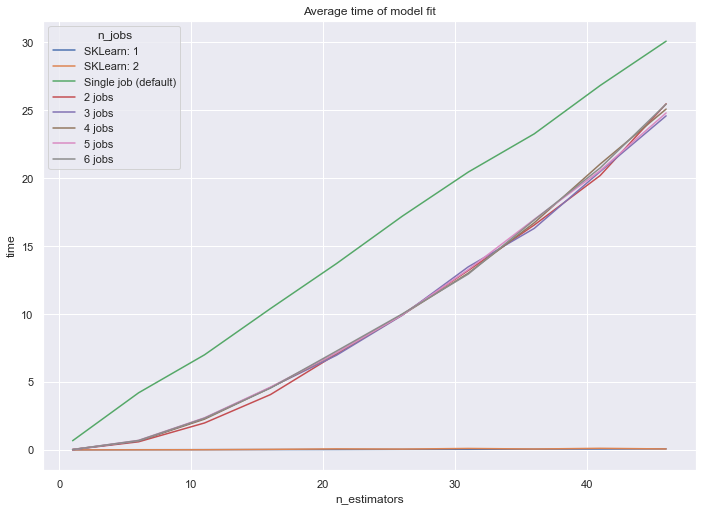

In [224]:
sns.lineplot(x='n_estimators', y='time', hue='n_jobs', data=results)
plt.title('Average time of model fit')
plt.show()

**Conclusion**: Increasing number of jobs makes performance better, but limited by number of CPU cores/logical processors. sklearn is very well optimized.